In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_california_housing

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.17.2
pandas 0.25.3
sklearn 0.21.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
house = fetch_california_housing()
print(house.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    house.data, house.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state=11)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

(11610, 8) (11610,)
(5160, 8) (5160,)
(3870, 8) (3870,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)


In [5]:
class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        '''初始化层次'''
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(CustomizedDenseLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        '''构建所需要的可训练参数'''
        self.kernel = self.add_weight(name='kernel', shape=(input_shape[1], self.units),
                                      initializer='uniform', trainable=True)
        self.bias = self.add_weight(name='bias', shape=(self.units, ),
                                    initializer='zeros', trainable=True)
        super(CustomizedDenseLayer, self).build(input_shape)
        
    def call(self, x):
        '''完成正向计算'''
        return self.activation(x @ self.kernel + self.bias)


model = keras.Sequential([
    CustomizedDenseLayer(30, activation='relu', input_shape=x_train.shape[1:]),
    CustomizedDenseLayer(1)
])
model.summary()
model.compile(loss='mean_squared_error', optimizer='sgd')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
customized_dense_layer (Cust (None, 30)                270       
_________________________________________________________________
customized_dense_layer_1 (Cu (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit(x_train_scaled, y_train,
                   validation_data=(x_valid_scaled, y_valid),
                   epochs=100,
                   callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 159us/sample - loss: 1.1080 - val_loss: 0.6324
Epoch 2/100
11610/11610 [==============================] - 1s 90us/sample - loss: 0.5497 - val_loss: 0.5443
Epoch 3/100
11610/11610 [==============================] - 1s 95us/sample - loss: 0.4883 - val_loss: 0.5030
Epoch 4/100
11610/11610 [==============================] - 1s 84us/sample - loss: 0.4600 - val_loss: 0.4752
Epoch 5/100
11610/11610 [==============================] - 1s 86us/sample - loss: 0.4626 - val_loss: 0.4988
Epoch 6/100
11610/11610 [==============================] - 1s 89us/sample - loss: 0.4470 - val_loss: 0.4526
Epoch 7/100
11610/11610 [==============================] - 1s 85us/sample - loss: 0.4346 - val_loss: 0.4460
Epoch 8/100
11610/11610 [==============================] - 1s 83us/sample - loss: 0.4239 - val_loss: 0.4374
Epoch 9/100
11610/11610 [==============================] - 1s 82us/sample - loss: 0.41

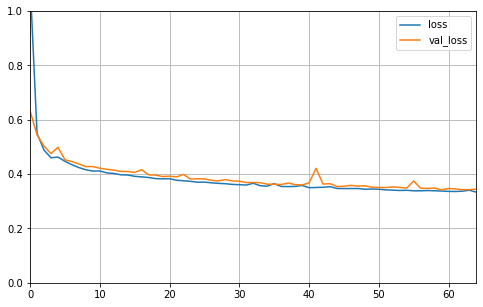

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)

In [8]:
model.evaluate(x_test_scaled, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.35558239434116573